In [1]:
library(tidyverse)
library(broom)
library(vegan)
library(cowplot)
library(patchwork)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.0 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots




# Beta Diversity analysis

##### Michael Shaffer
##### 7/21/22
##### Merck ESC, Sys bio group

This notebook builds out NMDS plots of the Kraken data. I also color the plots based on various metadata.

## Read in data

In [2]:
meta = read_csv('../../data/metadata/stool/stool_metadata.csv')
abx = read_csv('../../data/metadata/stool/stool_abx_usage.csv')
titers = read_csv('../../data/metadata/stool/stool_titers_yr1.csv')
meta = meta %>% left_join(abx, by='SampleID') %>% left_join(titers, by='SampleID')
meta = meta %>% mutate_at(vars(BabyN, Plate), factor)
head(meta)

Rows: 709 Columns: 26
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (11): SampleID, SubmissionType, DiversigenCheckInSampleName, BoxLocatio...
dbl   (7): SampleNumber, BabyN, Plate, Row, Column, age_at_collection, Count
lgl   (6): SampleIDValidation, BabyN_checked, DOB_checked, CollectionDate_ch...
date  (2): DOB, CollectionDate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 709 Columns: 6
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): SampleID
dbl (2): days_since_abx_start, days_since_abx_end
lgl (3): never_abx, on_abx, previous_abx

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set 

SampleID,SubmissionType,SampleNumber,SampleIDValidation,DiversigenCheckInSampleName,BoxLocation,SampleType,SampleSource,SequencingType,BabyN,⋯,median_mmNorm_PCV,median_mmNorm_DTAPHib,protectNorm_Dip,protectNorm_TET,protectNorm_PRP (Hib),protectNorm_PT,protectNorm_PRN,protectNorm_FHA,geommean_protectNorm,VR_group_v2
<chr>,<chr>,<dbl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
204_V5,Primary in Tube,1,NA,204_S,"Box 7, A1",Stool,Human Infant,MetaG,204,⋯,0.371980062,0.1927305,4.0,NA,NA,0.3125,0.6250,5.1250,1.4145587,LVR
226_V1,Primary in Tube,2,NA,NA,"Box 7, A2",Stool,Human Infant,MetaG,226,⋯,0.139576233,0.2057416,2.5,8.2,15.00000,0.7500,2.5000,1.3750,3.0422263,HVR
107_V3,Primary in Tube,3,NA,NA,"Box 7, A3",Stool,Human Infant,MetaG,107,⋯,0.958142022,0.1140184,4.4,5.2,10.66667,0.3125,1.1250,0.3750,1.7834178,NVR
108_V3,Primary in Tube,4,NA,NA,"Box 7, A4",Stool,Human Infant,MetaG,108,⋯,0.003102229,0.0000000,0.5,0.5,1.80000,0.3125,0.3125,0.1875,0.4494199,LVR
109_V1,Primary in Tube,5,NA,NA,"Box 7, A5",Stool,Human Infant,MetaG,109,⋯,0.486809637,0.7630493,NA,13.5,46.80000,3.3750,7.8750,NA,11.3835047,HVR
108_V2,Primary in Tube,6,NA,NA,"Box 7, A6",Stool,Human Infant,MetaG,108,⋯,0.003102229,0.0000000,0.5,0.5,1.80000,0.3125,0.3125,0.1875,0.4494199,LVR


In [3]:
abunds = t(read.table('../../data/stool/kraken_taxa_level_abunds/kraken_species_abunds.tsv', sep='\t', header=T, row.names=1, check.names=F, comment.char=""))
tail(abunds)

,d__Bacteria|g__Thermobaculum|s__Thermobaculum_terrenum,d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Acidobacterium|s__Acidobacterium_capsulatum,d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Candidatus_Koribacter|s__Candidatus_Koribacter_versatilis,d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Granulicella|s__Granulicella_mallensis,d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Granulicella|s__Granulicella_tundricola,d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Terriglobus|s__Terriglobus_roseus,d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Terriglobus|s__Terriglobus_saanensis,d__Bacteria|p__Acidobacteria|c__Blastocatellia|g__Chloracidobacterium|s__Chloracidobacterium_thermophilum,d__Bacteria|p__Acidobacteria|c__Solibacteres|o__Solibacterales|f__Solibacteraceae|g__Candidatus_Solibacter|s__Candidatus_Solibacter_usitatus,d__Bacteria|p__Actinobacteria|c__Acidimicrobiia|o__Acidimicrobiales|f__Acidimicrobiaceae|g__Acidimicrobium|s__Acidimicrobium_ferrooxidans,⋯,d__Bacteria|p__Verrucomicrobia|c__Opitutae|o__Puniceicoccales|f__Puniceicoccaceae|g__Coraliomargarita|s__Coraliomargarita_akajimensis,d__Bacteria|p__Verrucomicrobia|c__Spartobacteria|g__Candidatus_Xiphinematobacter|s__Candidatus_Xiphinematobacter_sp_Idaho_Grape,d__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae|g__Akkermansia|s__Akkermansia_glycaniphila,d__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae|g__Akkermansia|s__Akkermansia_muciniphila,d__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Verrucomicrobiaceae|g__Verrucomicrobium|s__Verrucomicrobium_spinosum,d__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Verrucomicrobiaceae|s__Verrucomicrobiaceae_bacterium_GAS474,d__Bacteria|p__Verrucomicrobia|s__Verrucomicrobia_bacterium,d__Bacteria|p__Verrucomicrobia|s__Verrucomicrobia_bacterium_IMCC26134,d__Bacteria|s__bacterium_2013Arg42i,d__Bacteria|s__bacterium_symbiont_of_Cryptopsaras_couesii
MSA2002_7A,0,2,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
MSA2002_7B,0,2,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
MSA2002_8A,0,1,0,1,0,0,0,0,0,0,⋯,0,0,0,1,0,0,0,0,0,0
MSA2002_8B,0,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
MSA2002_9A,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
MSA2002_9B,0,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [4]:
abunds_gt10 = abunds[, colSums(abunds) >= 10]
head(abunds_gt10)

,d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Acidobacterium|s__Acidobacterium_capsulatum,d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Candidatus_Koribacter|s__Candidatus_Koribacter_versatilis,d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Granulicella|s__Granulicella_mallensis,d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Granulicella|s__Granulicella_tundricola,d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Terriglobus|s__Terriglobus_roseus,d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Terriglobus|s__Terriglobus_saanensis,d__Bacteria|p__Acidobacteria|c__Blastocatellia|g__Chloracidobacterium|s__Chloracidobacterium_thermophilum,d__Bacteria|p__Acidobacteria|c__Solibacteres|o__Solibacterales|f__Solibacteraceae|g__Candidatus_Solibacter|s__Candidatus_Solibacter_usitatus,d__Bacteria|p__Actinobacteria|c__Acidimicrobiia|o__Acidimicrobiales|f__Acidimicrobiaceae|g__Acidimicrobium|s__Acidimicrobium_ferrooxidans,d__Bacteria|p__Actinobacteria|c__Acidimicrobiia|o__Acidimicrobiales|f__Acidimicrobiaceae|g__Ilumatobacter|s__Ilumatobacter_coccineus,⋯,d__Bacteria|p__Verrucomicrobia|c__Opitutae|o__Opitutales|f__Opitutaceae|g__Opitutus|s__Opitutus_terrae,d__Bacteria|p__Verrucomicrobia|c__Opitutae|o__Opitutales|f__Opitutaceae|s__Opitutaceae_bacterium_TAV5,d__Bacteria|p__Verrucomicrobia|c__Opitutae|o__Puniceicoccales|f__Puniceicoccaceae|g__Coraliomargarita|s__Coraliomargarita_akajimensis,d__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae|g__Akkermansia|s__Akkermansia_glycaniphila,d__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae|g__Akkermansia|s__Akkermansia_muciniphila,d__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Verrucomicrobiaceae|g__Verrucomicrobium|s__Verrucomicrobium_spinosum,d__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Verrucomicrobiaceae|s__Verrucomicrobiaceae_bacterium_GAS474,d__Bacteria|p__Verrucomicrobia|s__Verrucomicrobia_bacterium,d__Bacteria|p__Verrucomicrobia|s__Verrucomicrobia_bacterium_IMCC26134,d__Bacteria|s__bacterium_symbiont_of_Cryptopsaras_couesii
101_S1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
101_V3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
101_V5,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
102_V1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,2,0,0,7,0,0,0,0
102_V3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,3,0,0,6,0,0,0,0
102_V5,0,0,0,0,1,0,0,0,0,0,⋯,0,0,2,0,1,0,0,0,0,0


## Build NMDS with all data

In [5]:
nmds = metaMDS(abunds_gt10, k=3)

Square root transformation
Wisconsin double standardization
Run 0 stress 0.1495563 
Run 1 stress 0.149556 
... New best solution
... Procrustes: rmse 0.0001246759  max resid 0.001814482 
... Similar to previous best
Run 2 stress 0.1495568 
... Procrustes: rmse 0.0003685825  max resid 0.009360768 
... Similar to previous best
Run 3 stress 0.150045 
... Procrustes: rmse 0.003228768  max resid 0.0860912 
Run 4 stress 0.1506311 
Run 5 stress 0.1502562 
Run 6 stress 0.1502071 
Run 7 stress 0.1500901 
Run 8 stress 0.1495652 
... Procrustes: rmse 0.0006662707  max resid 0.01421967 
Run 9 stress 0.1497453 
... Procrustes: rmse 0.00269681  max resid 0.07199714 
Run 10 stress 0.1497721 
... Procrustes: rmse 0.002931113  max resid 0.07195808 
Run 11 stress 0.1495571 
... Procrustes: rmse 0.0002536968  max resid 0.005295837 
... Similar to previous best
Run 12 stress 0.1495551 
... New best solution
... Procrustes: rmse 0.0009131968  max resid 0.02348757 
Run 13 stress 0.1506849 
Run 14 stress 0.1

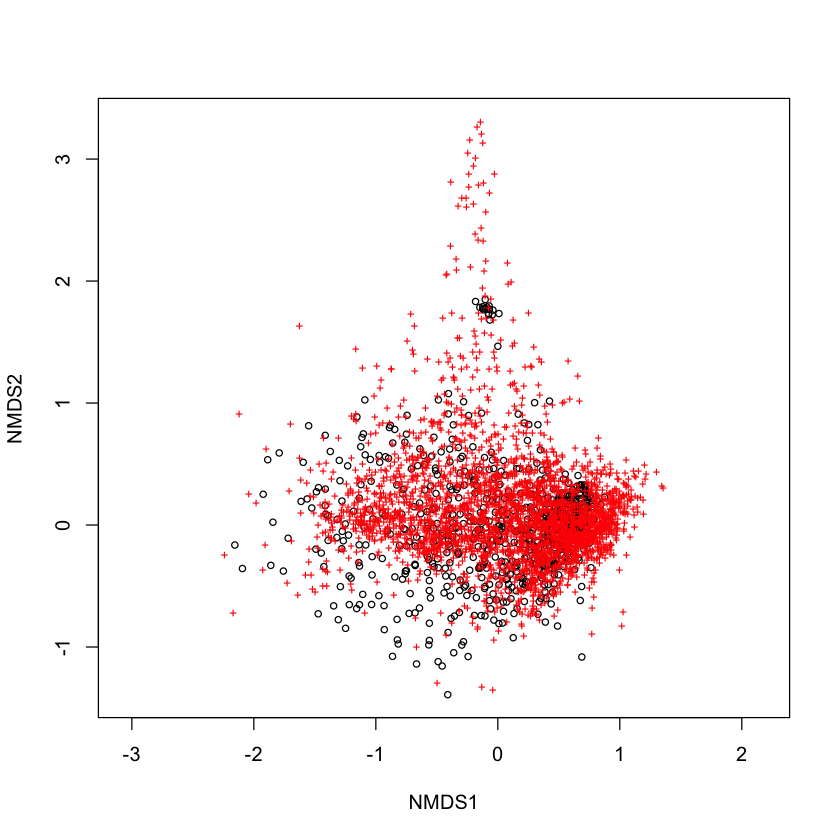

In [6]:
plot(nmds)

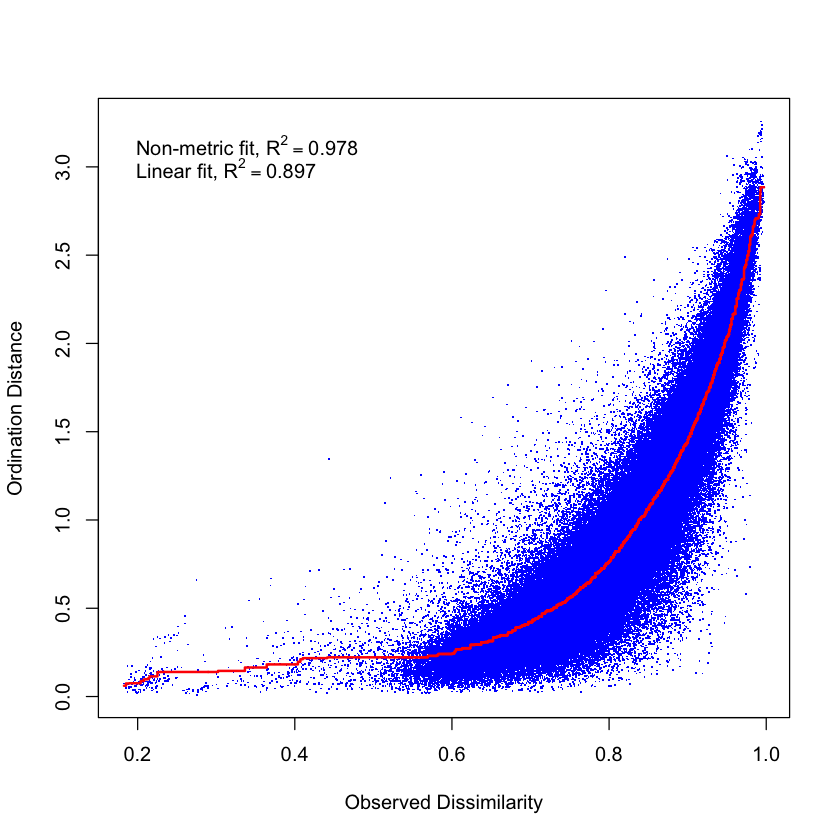

In [7]:
stressplot(nmds)

In [8]:
nmds$stress

[1] 0.1495551

Saving 7 x 7 in image


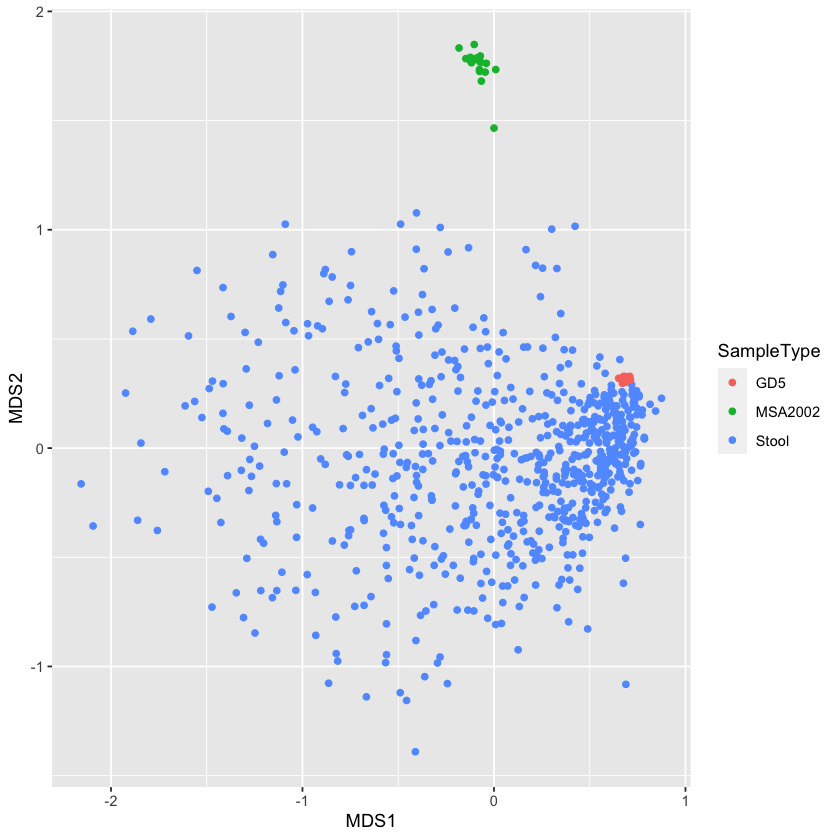

In [9]:
nmds_points = as_tibble(nmds$points, rownames='SampleID')
write_csv(nmds_points, '../../data/stool/kraken_nmds_all.csv')
baby_samples = left_join(meta, nmds_points, by='SampleID')
controls = nmds_points %>% 
              filter(!SampleID %in% baby_samples$SampleID) %>%
              separate(SampleID, 'SampleType', remove=F, extra='drop')
nmds_w_meta = bind_rows(baby_samples, controls)
kraken_nmds_all_sample_type = ggplot(nmds_w_meta, aes(x=MDS1, y=MDS2, col=SampleType)) + geom_point()
kraken_nmds_all_sample_type
ggsave("../../figures/kraken_nmds_all_sample_type.pdf", kraken_nmds_all_sample_type, dpi=300)

There is clear clustering by sample type. MSA2002 control samples cluster alone at the bottom of the plot. The GD5 samples cluster with the Stool samples but within a very confined range. This makes sense as the GD5 samples are from adult stool donors.

## NMDS of control samples only

In [10]:
abunds_controls = abunds_gt10[sapply(row.names(abunds_gt10), function(x) startsWith(x, 'GD5') | startsWith(x, 'MSA2002')),]
head(abunds_controls)

,d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Acidobacterium|s__Acidobacterium_capsulatum,d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Candidatus_Koribacter|s__Candidatus_Koribacter_versatilis,d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Granulicella|s__Granulicella_mallensis,d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Granulicella|s__Granulicella_tundricola,d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Terriglobus|s__Terriglobus_roseus,d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Terriglobus|s__Terriglobus_saanensis,d__Bacteria|p__Acidobacteria|c__Blastocatellia|g__Chloracidobacterium|s__Chloracidobacterium_thermophilum,d__Bacteria|p__Acidobacteria|c__Solibacteres|o__Solibacterales|f__Solibacteraceae|g__Candidatus_Solibacter|s__Candidatus_Solibacter_usitatus,d__Bacteria|p__Actinobacteria|c__Acidimicrobiia|o__Acidimicrobiales|f__Acidimicrobiaceae|g__Acidimicrobium|s__Acidimicrobium_ferrooxidans,d__Bacteria|p__Actinobacteria|c__Acidimicrobiia|o__Acidimicrobiales|f__Acidimicrobiaceae|g__Ilumatobacter|s__Ilumatobacter_coccineus,⋯,d__Bacteria|p__Verrucomicrobia|c__Opitutae|o__Opitutales|f__Opitutaceae|g__Opitutus|s__Opitutus_terrae,d__Bacteria|p__Verrucomicrobia|c__Opitutae|o__Opitutales|f__Opitutaceae|s__Opitutaceae_bacterium_TAV5,d__Bacteria|p__Verrucomicrobia|c__Opitutae|o__Puniceicoccales|f__Puniceicoccaceae|g__Coraliomargarita|s__Coraliomargarita_akajimensis,d__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae|g__Akkermansia|s__Akkermansia_glycaniphila,d__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae|g__Akkermansia|s__Akkermansia_muciniphila,d__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Verrucomicrobiaceae|g__Verrucomicrobium|s__Verrucomicrobium_spinosum,d__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Verrucomicrobiaceae|s__Verrucomicrobiaceae_bacterium_GAS474,d__Bacteria|p__Verrucomicrobia|s__Verrucomicrobia_bacterium,d__Bacteria|p__Verrucomicrobia|s__Verrucomicrobia_bacterium_IMCC26134,d__Bacteria|s__bacterium_symbiont_of_Cryptopsaras_couesii
GD5_1,0,5,0,14,0,0,0,0,0,3,⋯,0,23,0,511,84290,89,5,1,0,1
GD5_2,0,4,2,30,0,1,0,1,0,4,⋯,1,38,1,482,84414,86,4,1,1,0
GD5_3,0,4,2,25,0,1,1,0,0,2,⋯,1,31,0,572,95692,102,5,0,0,0
GD5_4,0,1,3,17,0,0,2,0,0,4,⋯,0,21,0,436,77431,84,3,0,1,0
GD5_5,0,5,2,31,0,1,0,0,0,4,⋯,0,29,0,503,90626,107,5,0,1,0
GD5_6,0,4,3,19,0,1,0,0,0,1,⋯,1,20,0,419,65756,68,4,0,0,1


In [11]:
nmds_controls = metaMDS(abunds_controls, k=2)

Square root transformation
Wisconsin double standardization
Run 0 stress 9.755555e-05 
Run 1 stress 9.969946e-05 
... Procrustes: rmse 0.0001311409  max resid 0.0006584274 
... Similar to previous best
Run 2 stress 9.144949e-05 
... New best solution
... Procrustes: rmse 0.0001139657  max resid 0.0005630781 
... Similar to previous best
Run 3 stress 9.981046e-05 
... Procrustes: rmse 6.27495e-05  max resid 0.0002313581 
... Similar to previous best
Run 4 stress 9.901672e-05 
... Procrustes: rmse 9.030224e-05  max resid 0.0002958904 
... Similar to previous best
Run 5 stress 9.223283e-05 
... Procrustes: rmse 7.724733e-05  max resid 0.0003426797 
... Similar to previous best
Run 6 stress 9.379616e-05 
... Procrustes: rmse 4.967573e-05  max resid 0.0001986674 
... Similar to previous best
Run 7 stress 9.646548e-05 
... Procrustes: rmse 9.111804e-05  max resid 0.0002813326 
... Similar to previous best
Run 8 stress 9.68221e-05 
... Procrustes: rmse 5.386452e-05  max resid 0.0001570615 
..

Warning message in metaMDS(abunds_controls, k = 2):
“stress is (nearly) zero: you may have insufficient data”


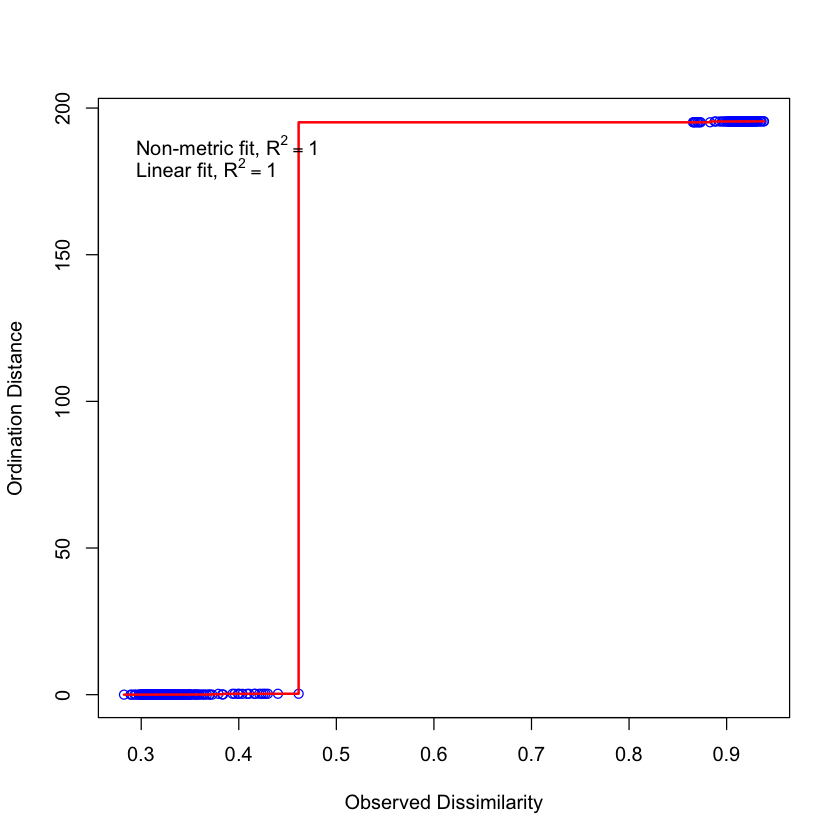

In [12]:
stressplot(nmds_controls)

In [13]:
nmds_controls$stress

[1] 8.890072e-05

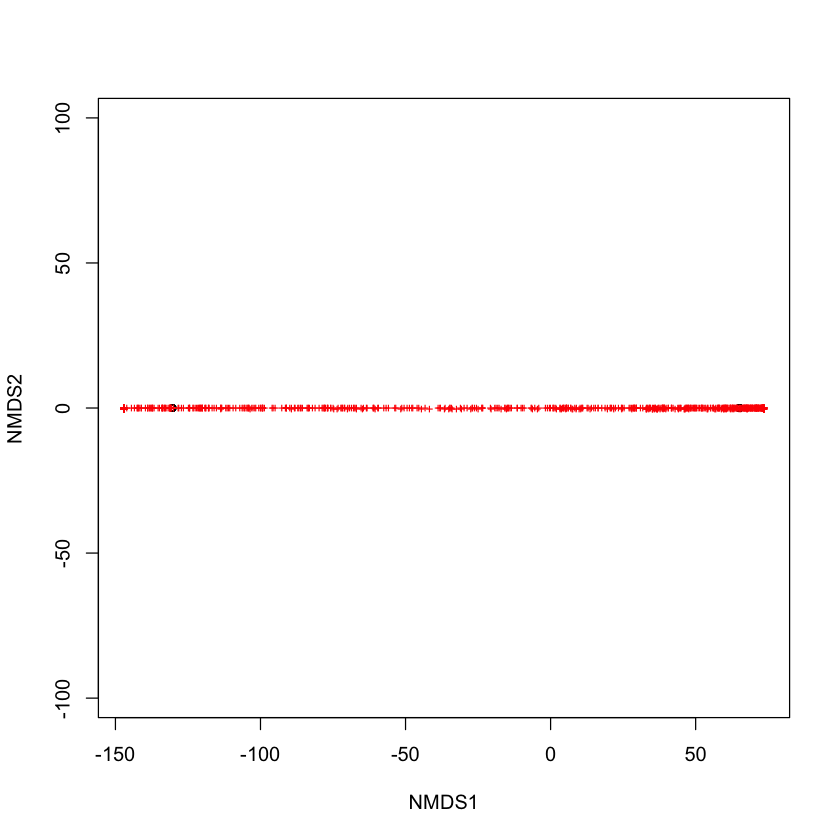

In [14]:
plot(nmds_controls)

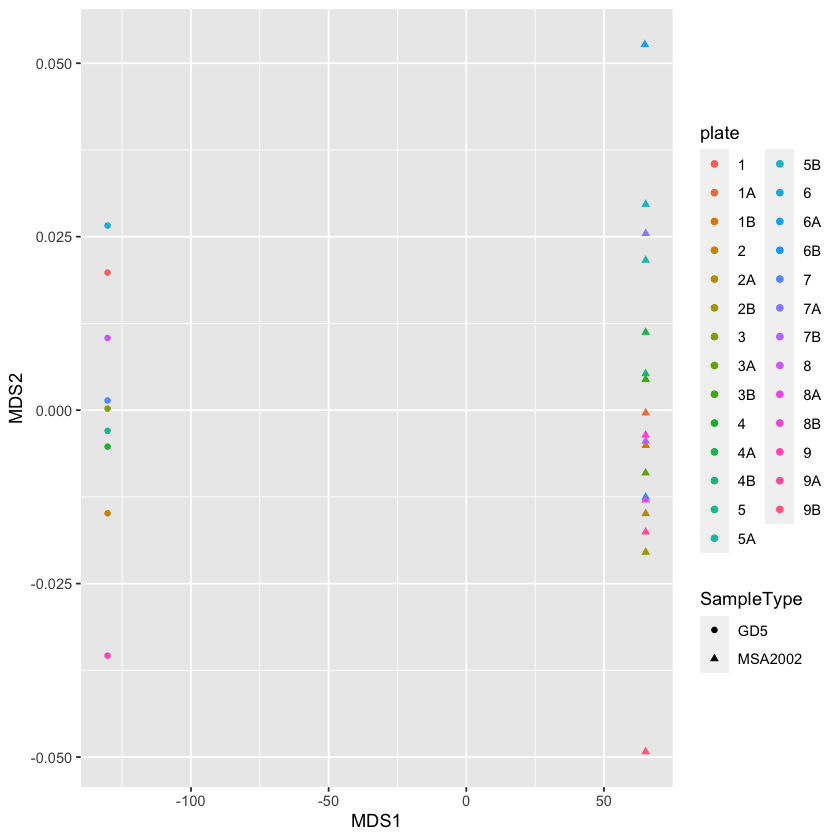

In [15]:
nmds_controls_points = as_tibble(nmds_controls$points, rownames='SampleID')
write_csv(nmds_controls_points, '../../data/stool/kraken_nmds_controls.csv')
controls_only = nmds_controls_points %>% 
                    separate(SampleID, c('SampleType', 'plate'), remove=F, extra='drop') %>%
                    mutate_at(vars('plate'), as.factor)
ggplot(controls_only, aes(x=MDS1, y=MDS2, shape=SampleType, col=plate)) + geom_point()

The difference is very much on the x-axis with very little variation on the y-axis. This makes us confident that the controls are doing what they should and we can trust our data.

## NMDS of baby samples

In [16]:
abunds_babies = abunds_gt10[sapply(row.names(abunds_gt10), function(x) !(startsWith(x, 'GD5') | startsWith(x, 'MSA2002'))),]
head(abunds_babies)

,d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Acidobacterium|s__Acidobacterium_capsulatum,d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Candidatus_Koribacter|s__Candidatus_Koribacter_versatilis,d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Granulicella|s__Granulicella_mallensis,d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Granulicella|s__Granulicella_tundricola,d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Terriglobus|s__Terriglobus_roseus,d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Terriglobus|s__Terriglobus_saanensis,d__Bacteria|p__Acidobacteria|c__Blastocatellia|g__Chloracidobacterium|s__Chloracidobacterium_thermophilum,d__Bacteria|p__Acidobacteria|c__Solibacteres|o__Solibacterales|f__Solibacteraceae|g__Candidatus_Solibacter|s__Candidatus_Solibacter_usitatus,d__Bacteria|p__Actinobacteria|c__Acidimicrobiia|o__Acidimicrobiales|f__Acidimicrobiaceae|g__Acidimicrobium|s__Acidimicrobium_ferrooxidans,d__Bacteria|p__Actinobacteria|c__Acidimicrobiia|o__Acidimicrobiales|f__Acidimicrobiaceae|g__Ilumatobacter|s__Ilumatobacter_coccineus,⋯,d__Bacteria|p__Verrucomicrobia|c__Opitutae|o__Opitutales|f__Opitutaceae|g__Opitutus|s__Opitutus_terrae,d__Bacteria|p__Verrucomicrobia|c__Opitutae|o__Opitutales|f__Opitutaceae|s__Opitutaceae_bacterium_TAV5,d__Bacteria|p__Verrucomicrobia|c__Opitutae|o__Puniceicoccales|f__Puniceicoccaceae|g__Coraliomargarita|s__Coraliomargarita_akajimensis,d__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae|g__Akkermansia|s__Akkermansia_glycaniphila,d__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae|g__Akkermansia|s__Akkermansia_muciniphila,d__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Verrucomicrobiaceae|g__Verrucomicrobium|s__Verrucomicrobium_spinosum,d__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Verrucomicrobiaceae|s__Verrucomicrobiaceae_bacterium_GAS474,d__Bacteria|p__Verrucomicrobia|s__Verrucomicrobia_bacterium,d__Bacteria|p__Verrucomicrobia|s__Verrucomicrobia_bacterium_IMCC26134,d__Bacteria|s__bacterium_symbiont_of_Cryptopsaras_couesii
101_S1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
101_V3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
101_V5,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
102_V1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,2,0,0,7,0,0,0,0
102_V3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,3,0,0,6,0,0,0,0
102_V5,0,0,0,0,1,0,0,0,0,0,⋯,0,0,2,0,1,0,0,0,0,0


In [17]:
nmds_babies = metaMDS(abunds_babies, k=3)

Square root transformation
Wisconsin double standardization
Run 0 stress 0.1538391 
Run 1 stress 0.1538267 
... New best solution
... Procrustes: rmse 0.001834437  max resid 0.03212043 
Run 2 stress 0.1550892 
Run 3 stress 0.1548651 
Run 4 stress 0.155334 
Run 5 stress 0.1539671 
... Procrustes: rmse 0.002654605  max resid 0.04653262 
Run 6 stress 0.1568503 
Run 7 stress 0.1538391 
... Procrustes: rmse 0.001208483  max resid 0.02049385 
Run 8 stress 0.1539034 
... Procrustes: rmse 0.001640875  max resid 0.03693927 
Run 9 stress 0.1541381 
... Procrustes: rmse 0.002682624  max resid 0.0547056 
Run 10 stress 0.1538922 
... Procrustes: rmse 0.002021127  max resid 0.04598138 
Run 11 stress 0.1539037 
... Procrustes: rmse 0.001453442  max resid 0.03561787 
Run 12 stress 0.1539036 
... Procrustes: rmse 0.001473486  max resid 0.03660814 
Run 13 stress 0.1539687 
... Procrustes: rmse 0.002756677  max resid 0.04777789 
Run 14 stress 0.1539181 
... Procrustes: rmse 0.002276374  max resid 0.03702

In [18]:
nmds_babies$stress

[1] 0.1538267

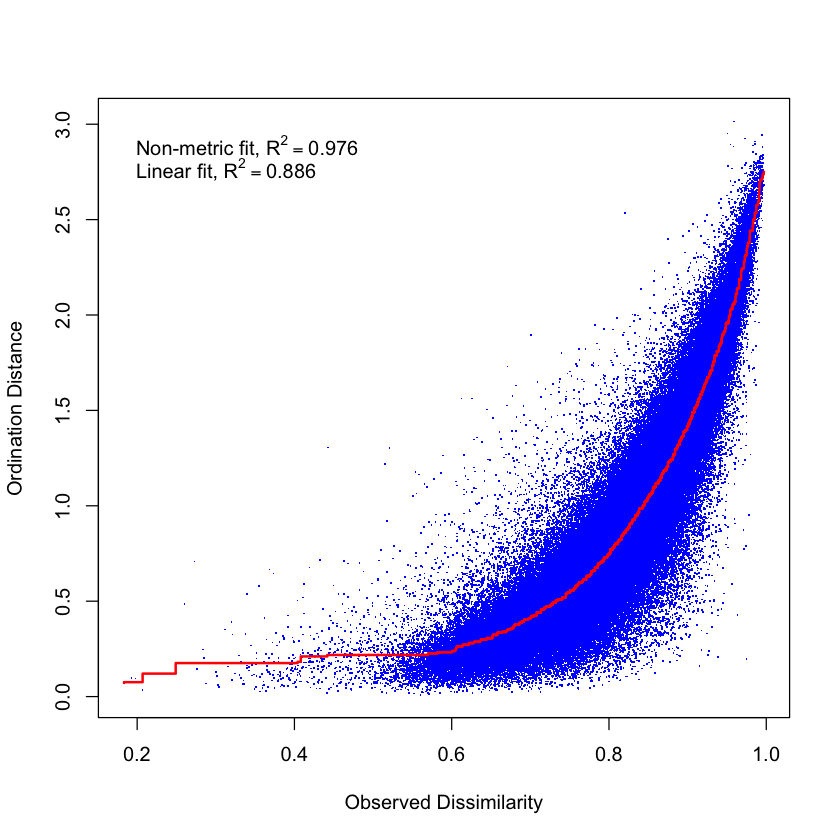

In [19]:
stressplot(nmds_babies)

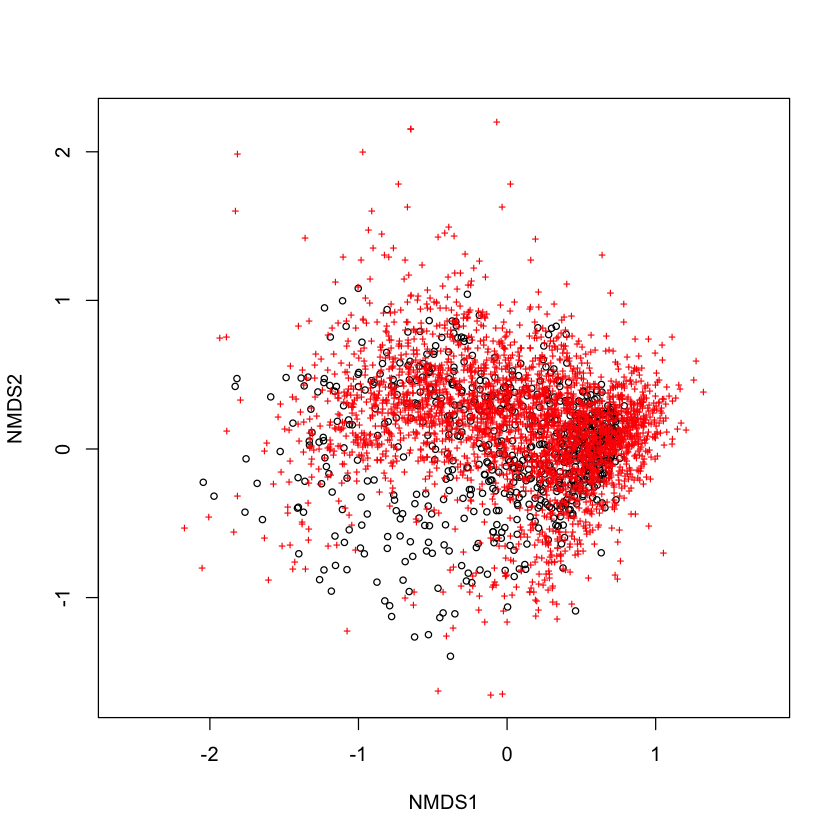

In [20]:
plot(nmds_babies)

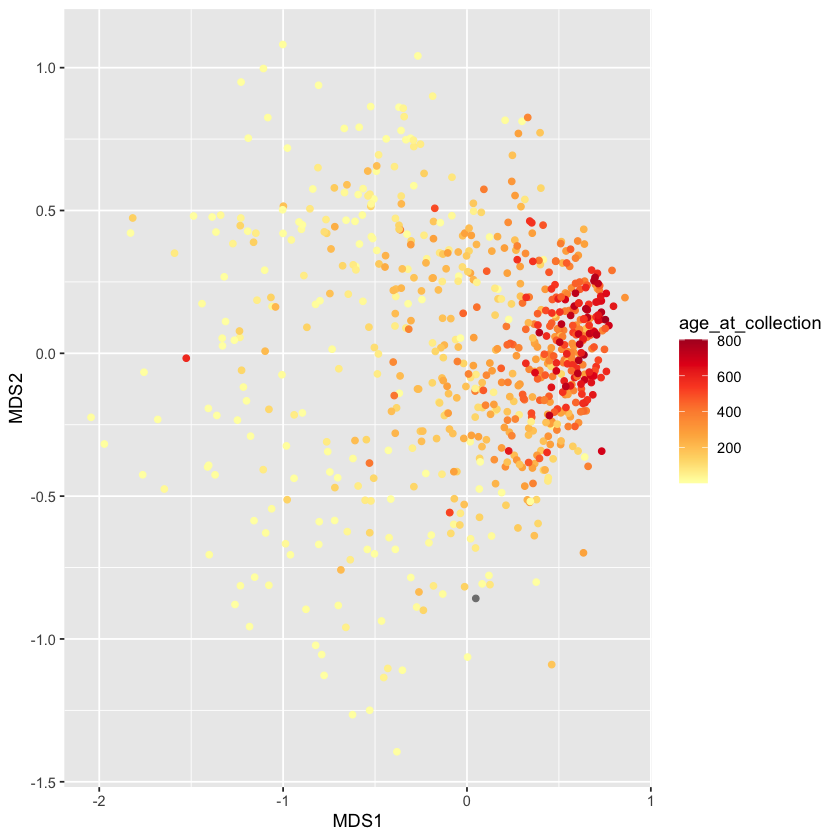

In [21]:
nmds_babies_points = as_tibble(nmds_babies$points, rownames='SampleID')
write_csv(nmds_babies_points, '../../data/stool/kraken_nmds_babies.csv')
baby_samples_only = left_join(meta, nmds_babies_points, by='SampleID')
ggplot(baby_samples_only, aes(x=MDS1, y=MDS2, color=age_at_collection)) + geom_point() + scale_color_distiller(palette = 'YlOrRd', direction = 1)

The NMDS colored by age. You babies are all over the left side of the plot. As they age they pull to the right and coalesce into a more common profile. Development seems to slow at around 1 year of age.

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


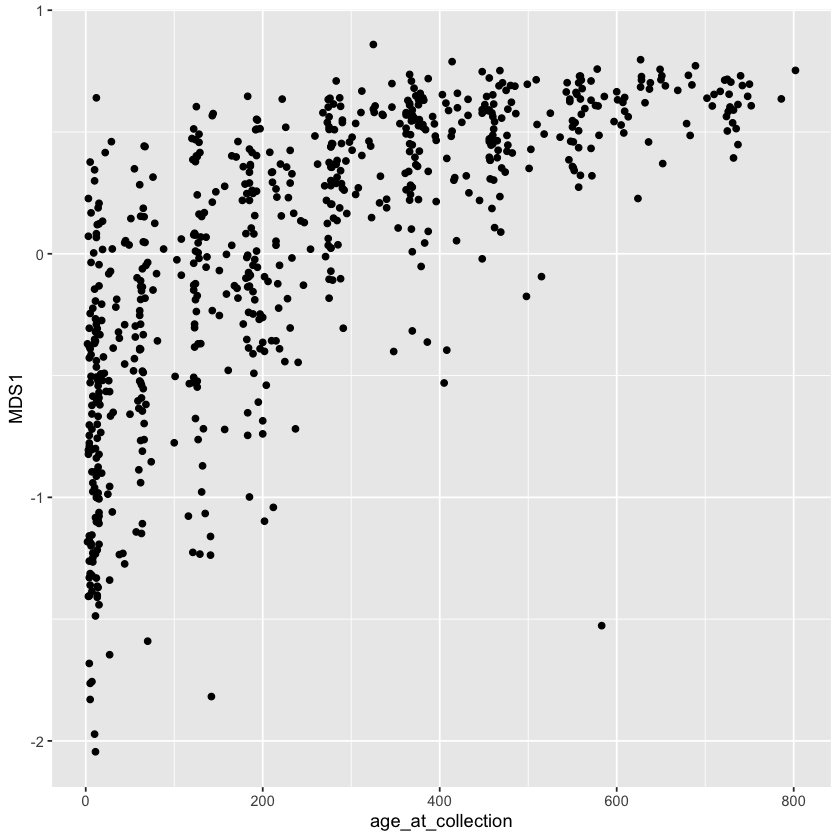

In [22]:
ggplot(baby_samples_only, aes(x=age_at_collection, y=MDS1)) + geom_point()

You can see this development with age a bit by plotting age vs MDS1. There are definitely more points high on MDS1 at higher ages. There is much more variability in MDS1 values at an early age but that variability goes away with age.

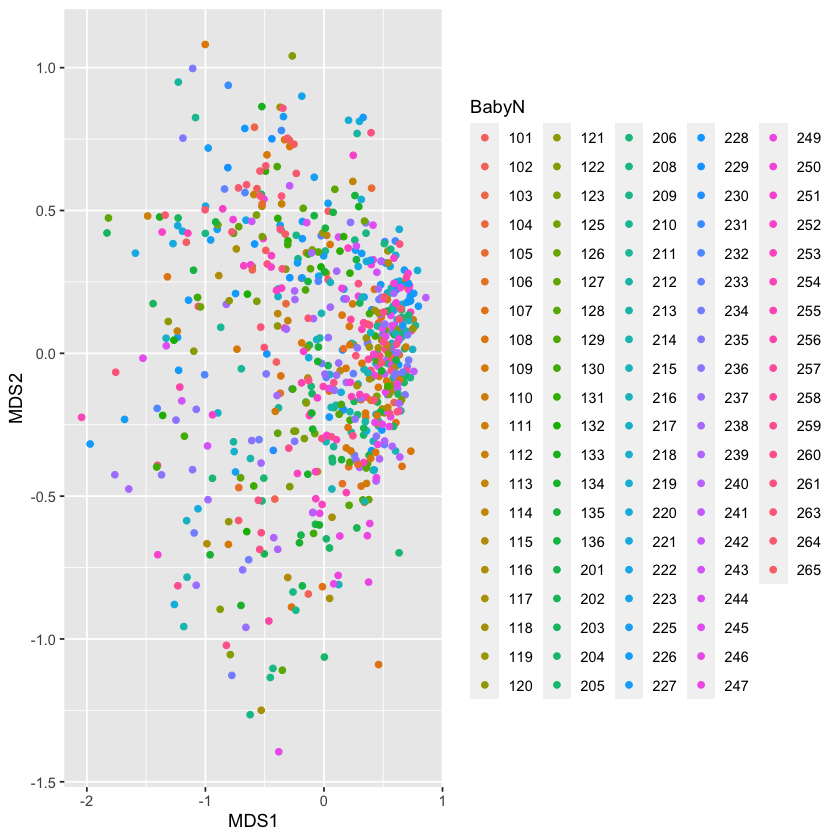

In [23]:
ggplot(baby_samples_only, aes(x=MDS1, y=MDS2, color=BabyN)) + geom_point()

No clear clustering by baby. That makes sense with the aging pattern.

Saving 7 x 7 in image


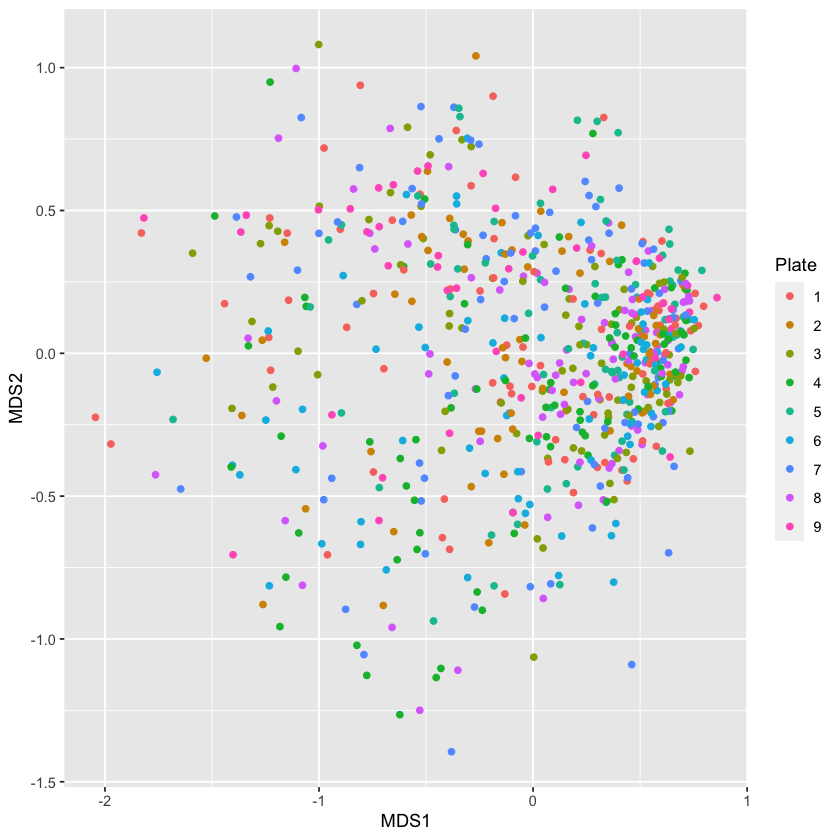

In [24]:
kraken_nmds_plate = ggplot(baby_samples_only, aes(x=MDS1, y=MDS2, color=Plate)) + geom_point()
kraken_nmds_plate
ggsave("../../figures/kraken_nmds_plate.pdf", kraken_nmds_plate, dpi=300)

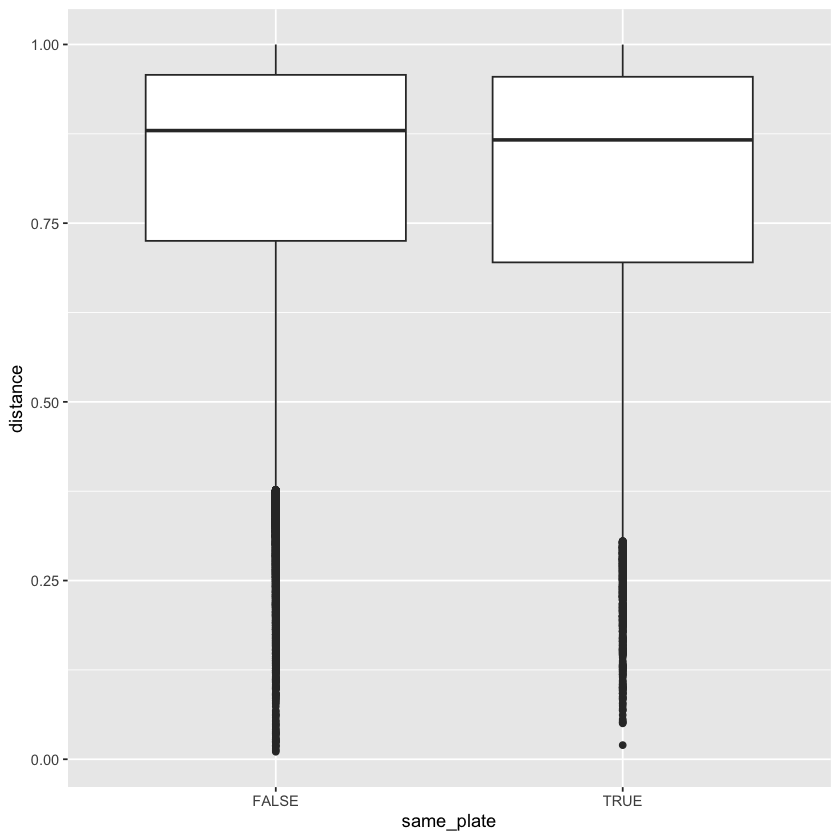

In [25]:
baby_bray_dists = tidy(vegdist(abunds_babies, 'bray'))

baby_bray_dists = baby_bray_dists %>% left_join((meta %>% select(c("SampleID", "Plate"))), by=c('item1' = 'SampleID')) %>% rename(plate1 = Plate) %>%
                                      left_join((meta %>% select(c("SampleID", "Plate"))), by=c('item2' = 'SampleID')) %>% rename(plate2 = Plate) %>%
                                      mutate(same_plate = plate1 == plate2) %>%
                                      left_join((meta %>% select(c("SampleID", "BabyN"))), by=c('item1' = 'SampleID')) %>% rename(baby1 = BabyN) %>%
                                      left_join((meta %>% select(c("SampleID", "BabyN"))), by=c('item2' = 'SampleID')) %>% rename(baby2 = BabyN) %>%
                                      mutate(same_baby = baby1 == baby2) %>%
                                      left_join((meta %>% select(c("SampleID", "age_at_collection"))), by=c('item1' = 'SampleID')) %>% rename(age1 = age_at_collection) %>%
                                      left_join((meta %>% select(c("SampleID", "age_at_collection"))), by=c('item2' = 'SampleID')) %>% rename(age2 = age_at_collection) %>%
                                      mutate(age_diff = abs(age1 - age2)) %>%
                                      left_join((meta %>% select(c("SampleID", "collection_method"))), by=c('item1' = 'SampleID')) %>% rename(collection1 = collection_method) %>%
                                      left_join((meta %>% select(c("SampleID", "collection_method"))), by=c('item2' = 'SampleID')) %>% rename(collection2 = collection_method) %>%
                                      mutate(same_collection = collection1 == collection2)
baby_bray_dists %>% ggplot(aes(same_plate, distance)) + geom_boxplot()

No difference in distances between different plates vs within the same plate.

### Color by collection type

Saving 7 x 7 in image


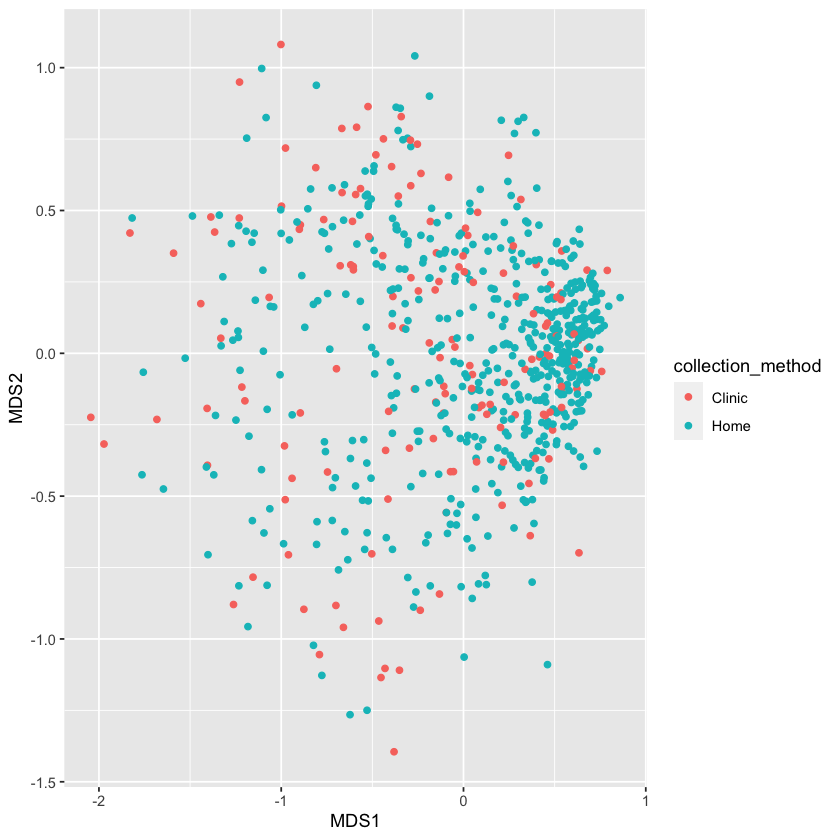

In [26]:
kraken_nmds_collection_method = ggplot(baby_samples_only, aes(x=MDS1, y=MDS2, color=collection_method)) + geom_point()
kraken_nmds_collection_method
ggsave("../../figures/kraken_nmds_collection_method.pdf", kraken_nmds_collection_method, dpi=300)

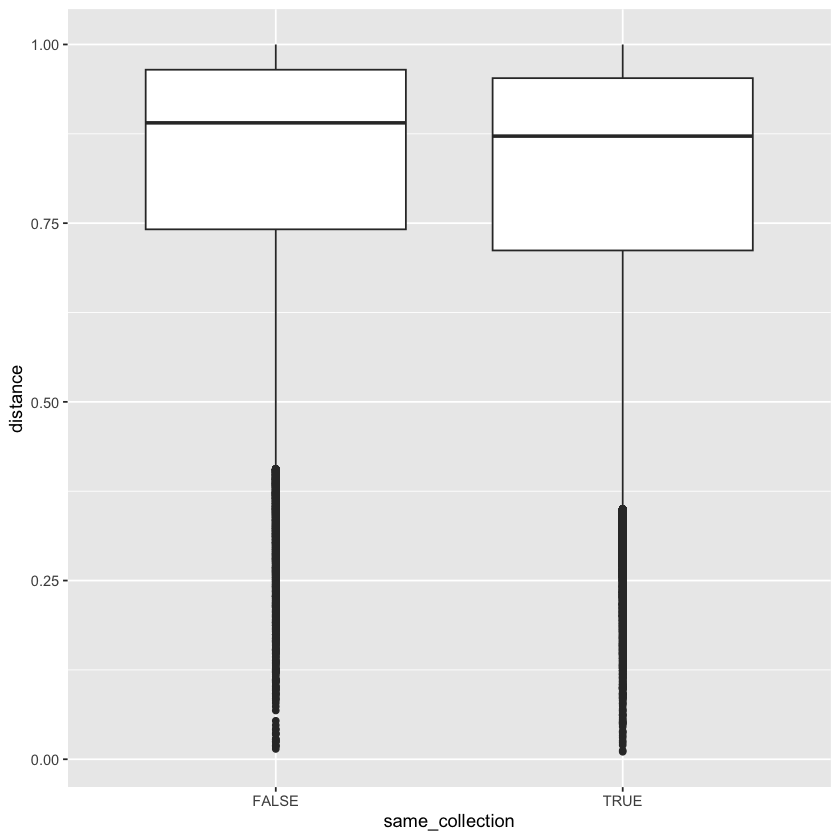

In [27]:
baby_bray_dists %>% ggplot(aes(same_collection, distance)) + geom_boxplot()

No clear effect of at home vs in clinic collection. Maybe some bias caused by more clinic collections in younger babies.

## Bring in antibiotics

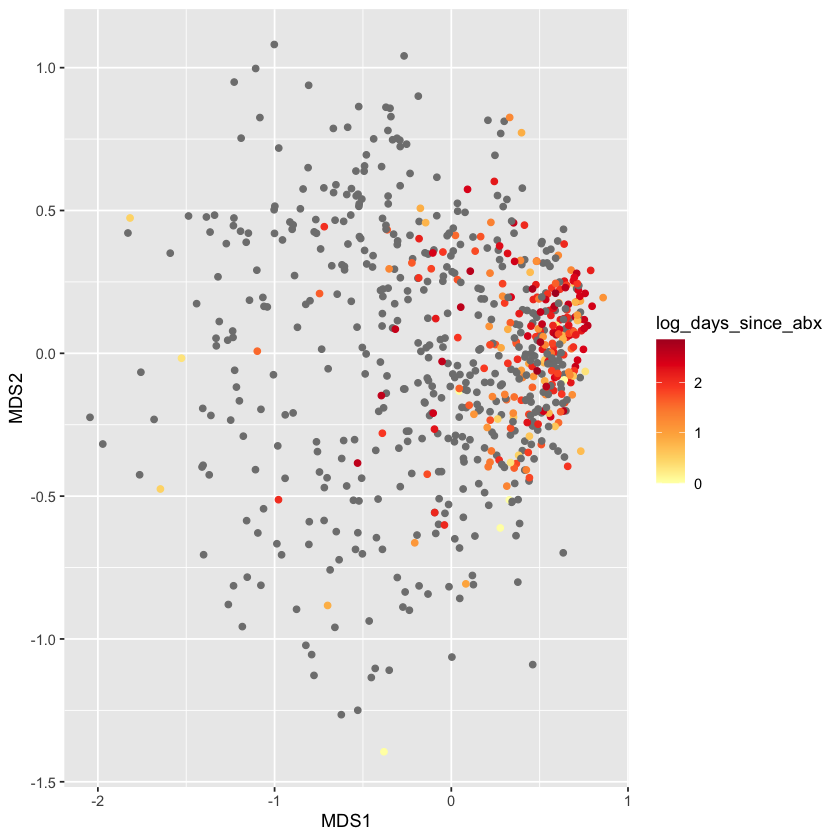

In [28]:
baby_samples_only %>% mutate(log_days_since_abx = log10(days_since_abx_end)) %>% ggplot(aes(x=MDS1, y=MDS2, color=log_days_since_abx)) + geom_point() + scale_color_distiller(palette = 'YlOrRd', direction = 1)

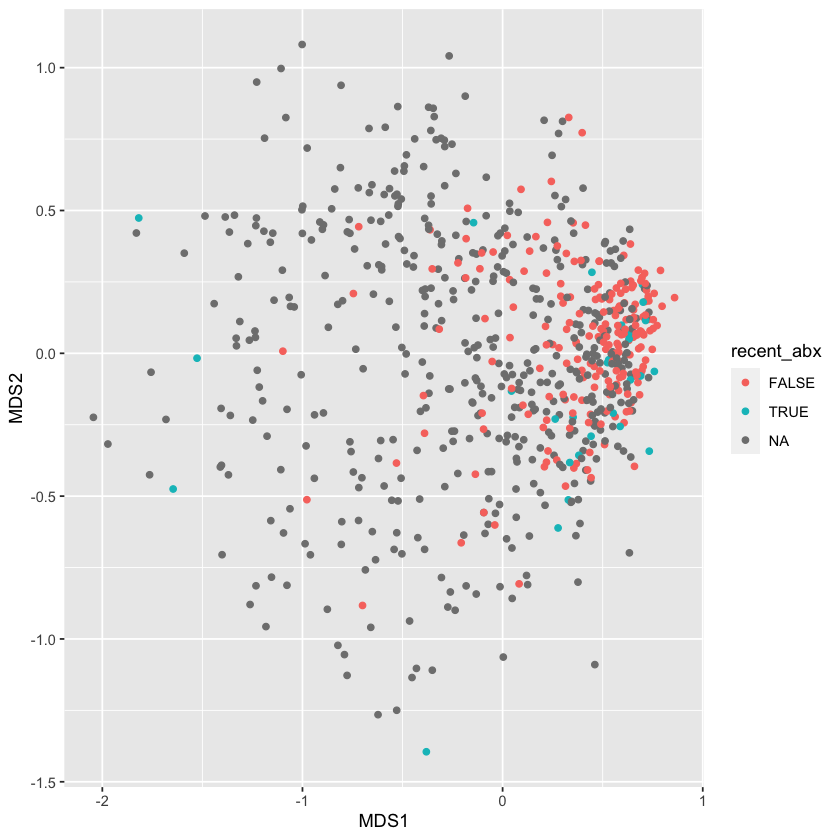

In [29]:
baby_samples_only %>% mutate(recent_abx = days_since_abx_end < 7) %>% ggplot(aes(x=MDS1, y=MDS2, color=recent_abx)) + geom_point()

The predicted outcome would be for samples where the baby had recently taken antibiotics to be on the left among the young samples. There is not strong evidence of this type of movement with abx treatment.

## Let's try filtering to idenify samples with pre+post antibiotics samples.

`age ~ MDS1 + days_since_abx + MDS1*days_since_abx`

Maybe `log(days_since_abx)`? down weight when there is a very long gap between antibiotics.

### First go for the outlier.

MDS1 < 1.5, MDS2 ~= .5, age = ~600

In [30]:
baby_samples_only %>% filter(MDS1 < -1) %>% filter(age_at_collection > 300)

SampleID,SubmissionType,SampleNumber,SampleIDValidation,DiversigenCheckInSampleName,BoxLocation,SampleType,SampleSource,SequencingType,BabyN,⋯,protectNorm_TET,protectNorm_PRP (Hib),protectNorm_PT,protectNorm_PRN,protectNorm_FHA,geommean_protectNorm,VR_group_v2,MDS1,MDS2,MDS3
<chr>,<chr>,<dbl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
245_S2,Primary in Tube,615,NA,NA,Box18,Stool,Human Infant,MetaG,245,⋯,1,5.733333,0.3125,0.3125,1.25,0.9422574,LVR,-1.526821,-0.01709182,0.8306244


In [31]:
baby_samples_only %>%  filter(BabyN == 245) %>% arrange(age_at_collection) %>% select(SampleID, age_at_collection)

SampleID,age_at_collection
<chr>,<dbl>
245_V2,10
245_V4,44
245_V6,128
245_V7,194
245_A1,268
245_V8,275
245_A3,362
245_V9,381
245_V10,482


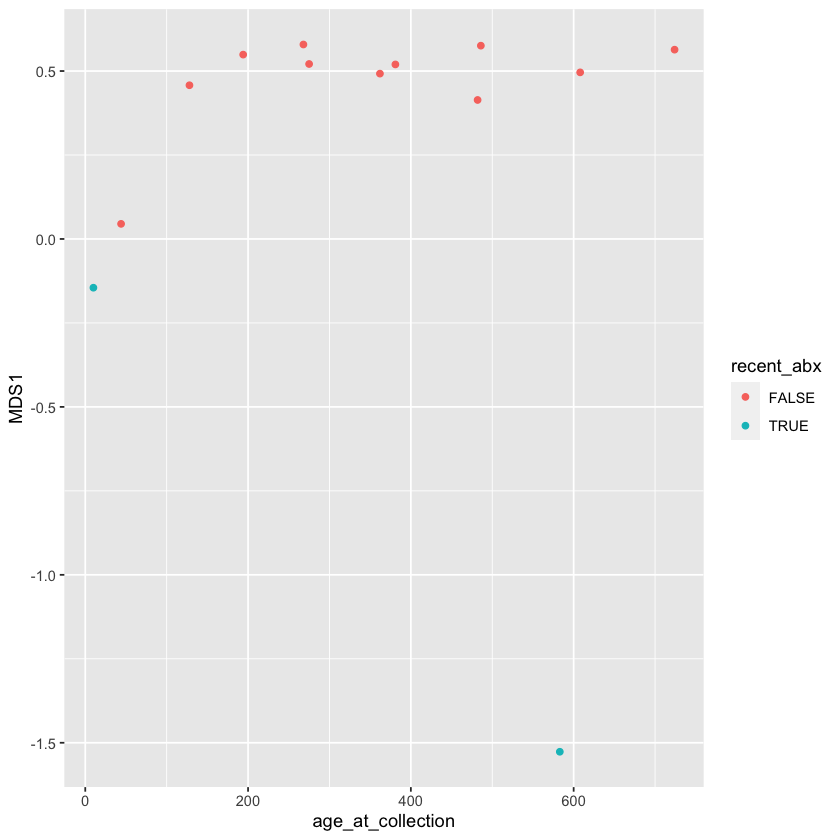

In [32]:
baby_samples_only %>% mutate(recent_abx = days_since_abx_end < 7) %>% filter(BabyN == 245) %>% ggplot(aes(x=age_at_collection, y=MDS1, color=recent_abx)) + geom_point()

Look it's signal of antibiotics as we would hope! Unfortunately we didn't see this strong of a signal regularly in the data.

## Add in responder status

### Binary vaccine response

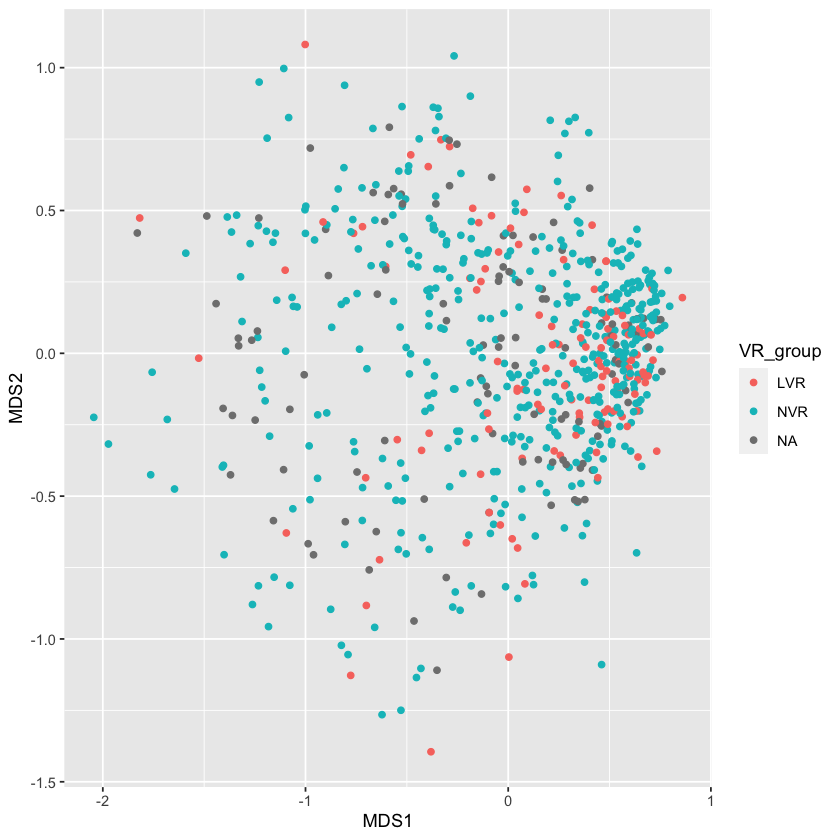

In [33]:
baby_samples_only %>% ggplot(aes(x=MDS1, y=MDS2, color=VR_group)) + geom_point()

Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Using alpha for a discrete variable is not advised.”


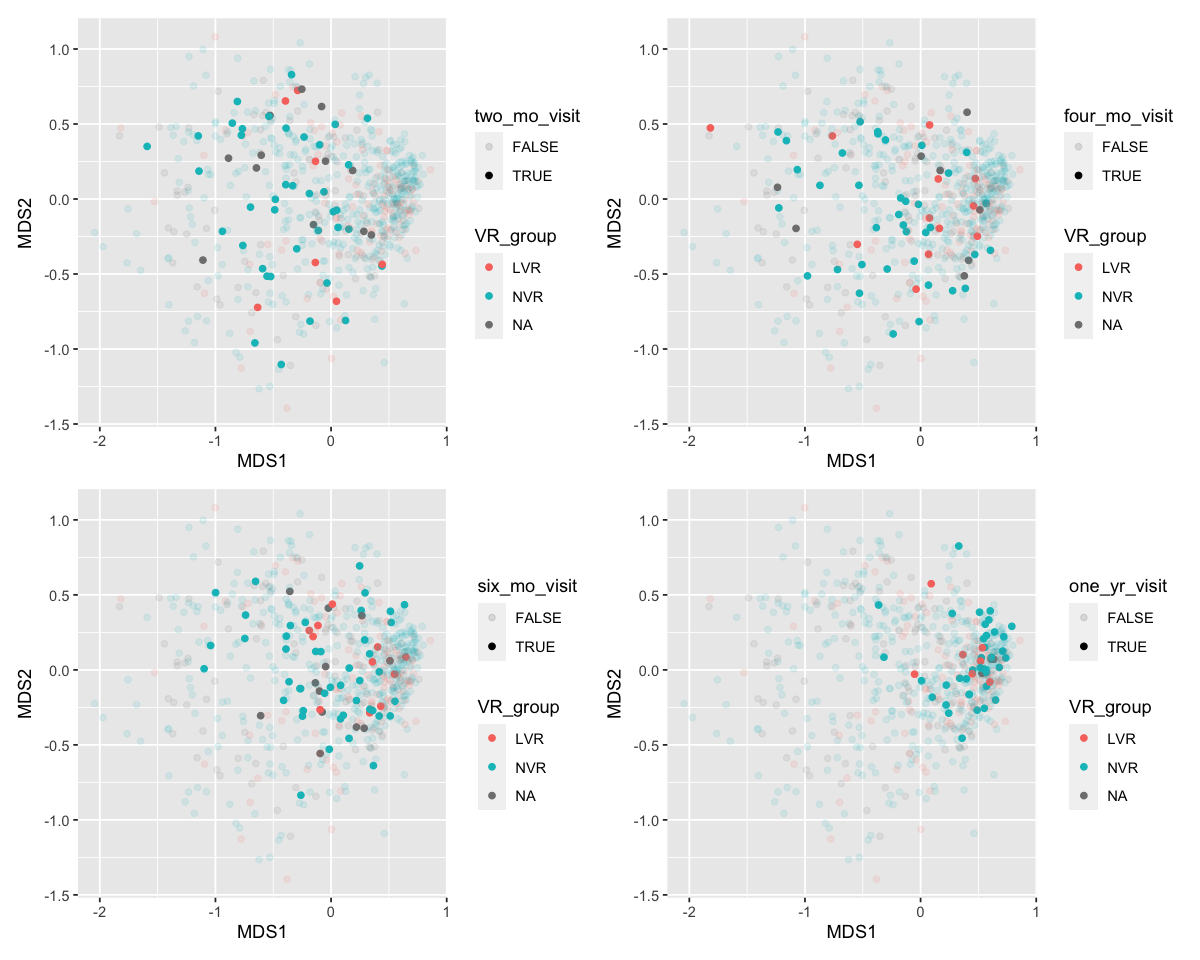

In [34]:
vr_two_month_plot = baby_samples_only %>% mutate('two_mo_visit' = VisitCode == 'V5') %>% ggplot(aes(x=MDS1, y=MDS2, color=VR_group, alpha=two_mo_visit)) + geom_point()
vr_four_month_plot = baby_samples_only %>% mutate('four_mo_visit' = VisitCode == 'V6') %>% ggplot(aes(x=MDS1, y=MDS2, color=VR_group, alpha=four_mo_visit)) + geom_point()
vr_six_month_plot = baby_samples_only %>% mutate('six_mo_visit' = VisitCode == 'V7') %>% ggplot(aes(x=MDS1, y=MDS2, color=VR_group, alpha=six_mo_visit)) + geom_point()
vr_one_year_plot = baby_samples_only %>% mutate('one_yr_visit' = VisitCode == 'V9') %>% ggplot(aes(x=MDS1, y=MDS2, color=VR_group, alpha=one_yr_visit)) + geom_point()
options(repr.plot.width = 10, repr.plot.height = 8)
vr_two_month_plot + vr_four_month_plot + vr_six_month_plot + vr_one_year_plot

No clear pattern of vaccine reponse across all time points or within the 2, 4, 6 and 12 month timepoints specifically.

### Continuous vaccine response

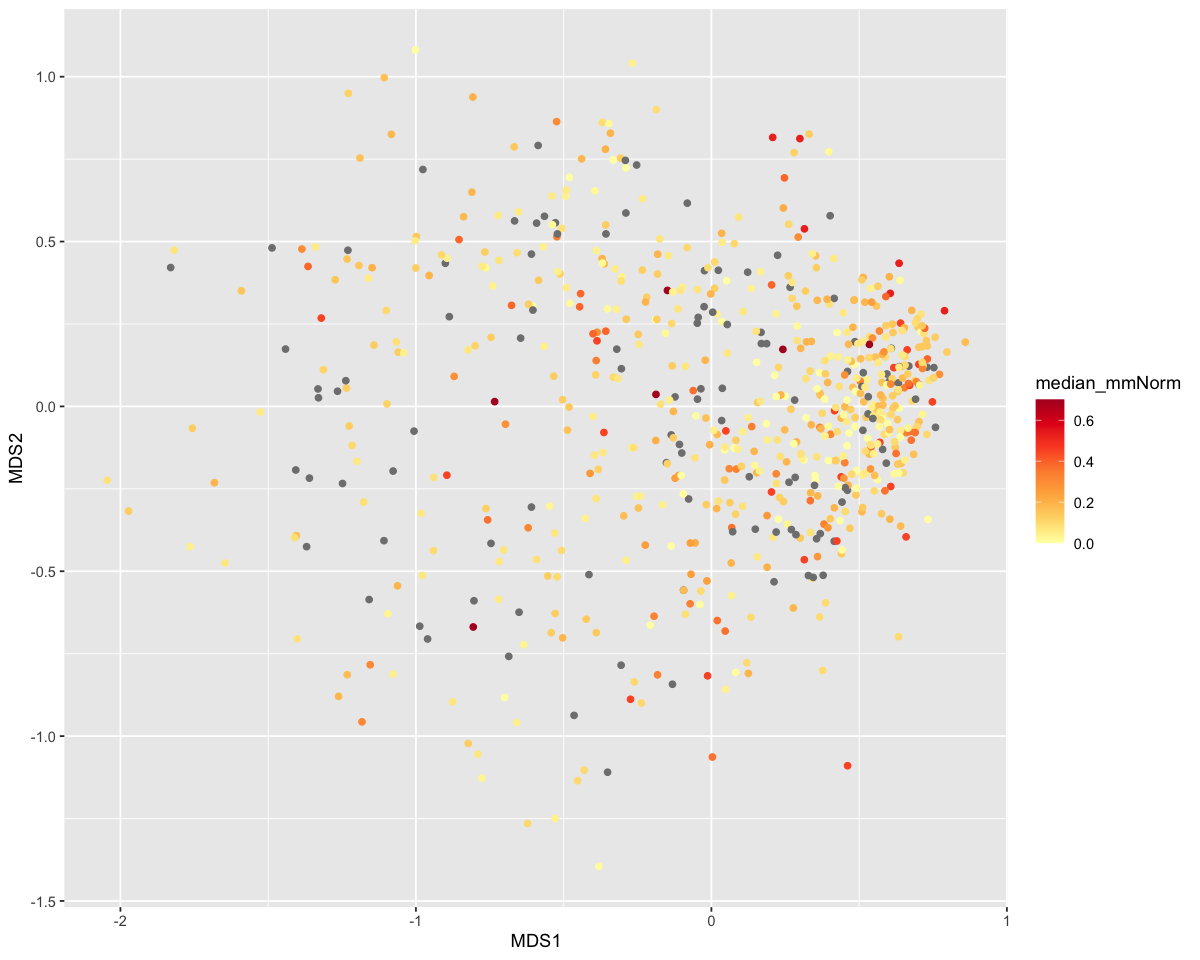

In [35]:
baby_samples_only %>% ggplot(aes(x=MDS1, y=MDS2, color=median_mmNorm)) + geom_point() + scale_color_distiller(palette = 'YlOrRd', direction = 1)

Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Using alpha for a discrete variable is not advised.”


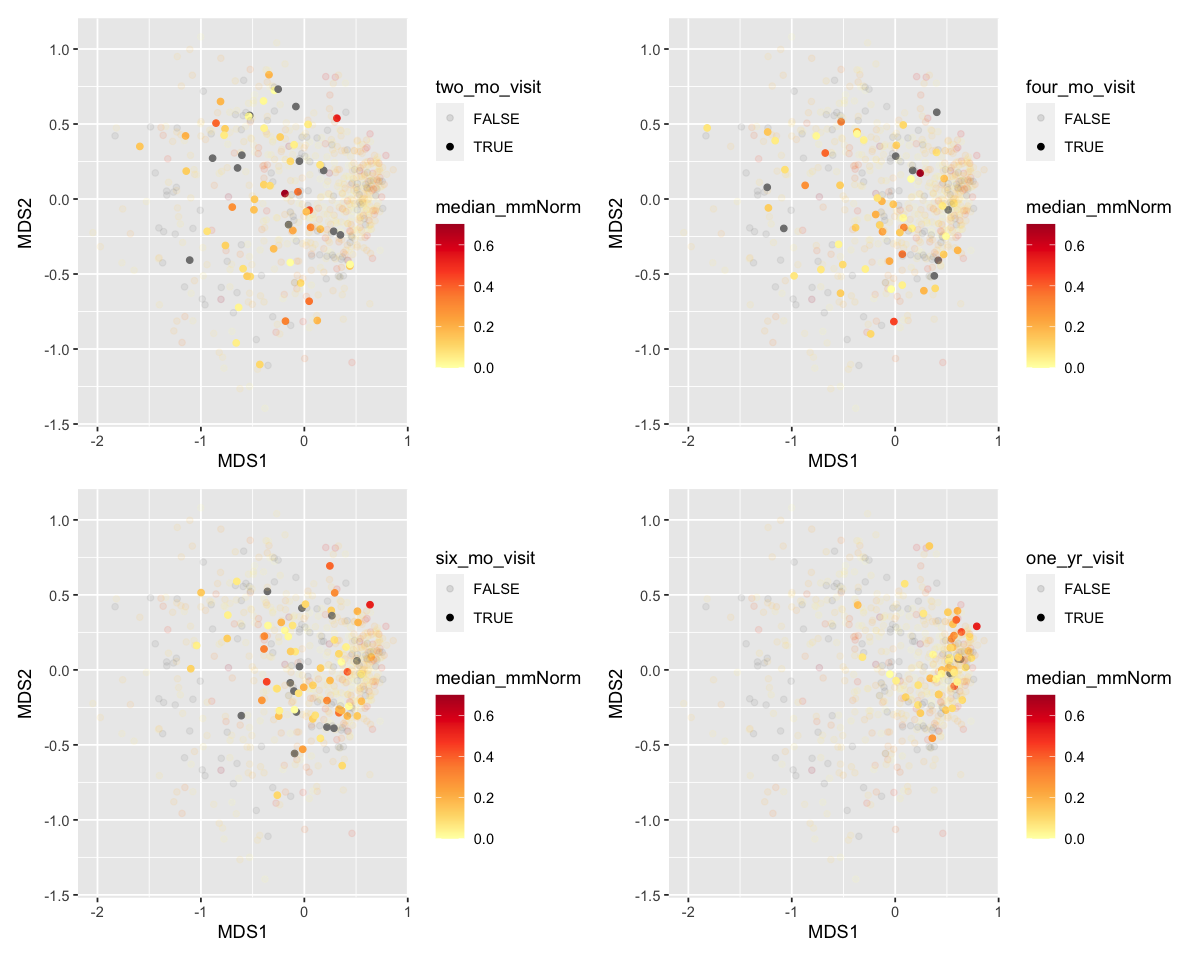

In [36]:
titer_two_month_plot = baby_samples_only %>% mutate('two_mo_visit' = VisitCode == 'V5') %>% ggplot(aes(x=MDS1, y=MDS2, color=median_mmNorm, alpha=two_mo_visit)) + geom_point() + scale_color_distiller(palette = 'YlOrRd', direction = 1)
titer_four_month_plot = baby_samples_only %>% mutate('four_mo_visit' = VisitCode == 'V6') %>% ggplot(aes(x=MDS1, y=MDS2, color=median_mmNorm, alpha=four_mo_visit)) + geom_point() + scale_color_distiller(palette = 'YlOrRd', direction = 1)
titer_six_month_plot = baby_samples_only %>% mutate('six_mo_visit' = VisitCode == 'V7') %>% ggplot(aes(x=MDS1, y=MDS2, color=median_mmNorm, alpha=six_mo_visit)) + geom_point() + scale_color_distiller(palette = 'YlOrRd', direction = 1)
titer_one_year_plot = baby_samples_only %>% mutate('one_yr_visit' = VisitCode == 'V9') %>% ggplot(aes(x=MDS1, y=MDS2, color=median_mmNorm, alpha=one_yr_visit)) + geom_point() + scale_color_distiller(palette = 'YlOrRd', direction = 1)
options(repr.plot.width = 10, repr.plot.height = 8)
titer_two_month_plot + titer_four_month_plot + titer_six_month_plot + titer_one_year_plot

No clear pattern of vaccine reponse across all time points or within the 2, 4, 6 and 12 month timepoints specifically.